In [142]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F

In [143]:
# open text file and read in data as `text`

text =  open(r'D:\Final Year Project\Codes\Neural Network Model\cleanedAllNames.txt', 'r', encoding='utf-8').read()
names =  open(r'D:\Final Year Project\Codes\Neural Network Model\cleanedAllNames.txt', 'r', encoding='utf-8').readlines()

In [144]:
text[:100]

'අංකඩගේ\nඅංකිලිපිටියේ\nඅංකුඹුරගේ\nඅංකුඹුරේ\nඅංකෙලිපිටියේ\nඅංකේලි\nඅංකොක්කාවල\nඅංගගේ\nඅංගප්පන්\nඅංගප්පුලි\nඅංගප්'

In [145]:
names[:5]

['අංකඩගේ\n', 'අංකිලිපිටියේ\n', 'අංකුඹුරගේ\n', 'අංකුඹුරේ\n', 'අංකෙලිපිටියේ\n']

In [146]:
# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = list(set(text)) + ['<PAD>']
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])

In [152]:
encoded = np.ones((len(names),25), dtype='int32')*char2int['<PAD>']
for i, name in enumerate(names):
    for j, ch in enumerate(name):
        encoded[i][j] = char2int[ch]
np.random.shuffle(encoded)

In [153]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [154]:
# check that the function works as expected
test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


In [155]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [156]:


batches = get_batches(encoded, 8, 50)
x, y = next(batches)


In [157]:
x.shape

(8, 50)

In [158]:
# printing out the first 10 items in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[34 56 38 12  5 38  0 65 65 65]
 [21 45 11 25 36 13 38  0 65 65]
 [44 18 46 25 41  0 65 65 65 65]
 [37 11  7 41 37 38 37 14  0 65]
 [59 11 53 38  5 46 13 38 25 14]
 [37 41 53 11  5 38  0 65 65 65]
 [61 37 38 59 11  5 37 38  0 65]
 [21 27 38 44 11 53 41  0 65 65]]

y
 [[56 38 12  5 38  0 65 65 65 65]
 [45 11 25 36 13 38  0 65 65 65]
 [18 46 25 41  0 65 65 65 65 65]
 [11  7 41 37 38 37 14  0 65 65]
 [11 53 38  5 46 13 38 25 14  0]
 [41 53 11  5 38  0 65 65 65 65]
 [37 38 59 11  5 37 38  0 65 65]
 [27 38 44 11 53 41  0 65 65 65]]


In [159]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [160]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=512, n_layers=3,
                               drop_prob=0.3, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [179]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    pad_index = char2int['<PAD>']
    criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    training_losses = []
    validation_losses=[]
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            # print(output.shape, targets.view(batch_size*seq_length).long().shape)
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()

            training_losses.append(loss.item())
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                    validation_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))


    plt.figure()
    plt.plot(validation_losses)

In [180]:
# define and print the net
n_hidden=8
n_layers=4

net = CharRNN(chars, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(66, 8, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=8, out_features=66, bias=True)
)


Epoch: 1/2... Step: 10... Loss: 3.4744... Val Loss: 3.4186
Epoch: 1/2... Step: 20... Loss: 3.5156... Val Loss: 3.3647
Epoch: 1/2... Step: 30... Loss: 3.3267... Val Loss: 3.3110
Epoch: 1/2... Step: 40... Loss: 3.3233... Val Loss: 3.3142
Epoch: 1/2... Step: 50... Loss: 3.2710... Val Loss: 3.2942
Epoch: 1/2... Step: 60... Loss: 3.1872... Val Loss: 3.2863
Epoch: 1/2... Step: 70... Loss: 3.3480... Val Loss: 3.2937
Epoch: 1/2... Step: 80... Loss: 3.3214... Val Loss: 3.2871
Epoch: 1/2... Step: 90... Loss: 3.2900... Val Loss: 3.2819
Epoch: 1/2... Step: 100... Loss: 3.3878... Val Loss: 3.2776
Epoch: 1/2... Step: 110... Loss: 3.2311... Val Loss: 3.2824
Epoch: 1/2... Step: 120... Loss: 3.2713... Val Loss: 3.2883
Epoch: 1/2... Step: 130... Loss: 3.3872... Val Loss: 3.2884
Epoch: 1/2... Step: 140... Loss: 3.2076... Val Loss: 3.2867
Epoch: 1/2... Step: 150... Loss: 3.2563... Val Loss: 3.2792
Epoch: 1/2... Step: 160... Loss: 3.3451... Val Loss: 3.2815
Epoch: 1/2... Step: 170... Loss: 3.3570... Val Lo

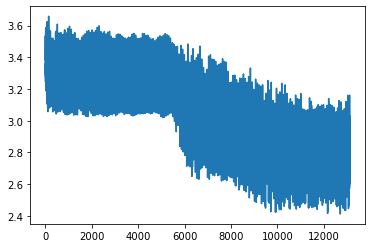

In [181]:
batch_size = 8
seq_length = 25
n_epochs = 2 # start smaller if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.030, print_every=10)



In [182]:
# # change the name, for saving multiple files
# model_name = 'rnn_20_epoch.net'

# checkpoint = {'n_hidden': net.n_hidden,
#               'n_layers': net.n_layers,
#               'state_dict': net.state_dict(),
#               'tokens': net.chars}

# with open(model_name, 'wb') as f:
#     torch.save(checkpoint, f)

In [183]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

In [184]:
def sample(net, size, prime='Once upon a time', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [196]:
h = net.init_hidden(1)
predict(net, 'අත්', h, top_k=5)[0]

'ල'

In [193]:
print(sample(net, 8, prime='රත්නාය', top_k=10))

රත්නායි
ා
්
න්



In [188]:
# Here we have loaded in a model that trained over 20 epochs `rnn_20_epoch.net`
with open('rnn_20_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
# Sample using a loaded model
print(sample(loaded, 2000, top_k=5, prime="The beautiful"))

The beautiful cried was the best of
the castle, and asked all the house.

The King appraned to shut themselves because he had nothing at lint, and he set his pack, and she
thick was standing to the maiden. But the King went and began to
say. And she said that the King and caught her and was so things of they sang, but they
light it to home, and said,
“And no longer straight into
a tree and want, and to must see itself beside the children will be shuning from him before he, sid they will soon asked her beautiful daughter.”

At last, the maiden cried, “What sought itself? I had a song fairest with tired.”

“Alas,” said the mother, “I will say:

    “_Blow, bleat, my little beard to you?” but a single continued and traveled away from the bed and said, “Now I will not do you. As I am so beautiful that I have to do you this.”

When the King’s Daughter had grown forether on the second time to himself, and the
stones came and before the King’s Son covered with her. And in the three laskest sh